In [132]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [133]:
window = 20

file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

df = df.sort_values(by='Date')

targ = 'LMCADY'.format(window)
time_series = df[targ]

time_series*=100

In [134]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.015, shuffle=False)

In [135]:
def find_best_garch(time_series, max_p=10, max_q=10):
    p = range(1, max_p + 1)
    q = range(1, max_q + 1)
    
    best_aic = float("inf")
    best_param = None
    
    for param_p, param_q in itertools.product(p, q):
        try:
            model = arch_model(time_series, vol='Garch', p=param_p, q=param_q)
            results = model.fit(disp='off')
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = (param_p, param_q)
        except Exception as e:
            print('Error al ajustar GARCH con p={}, q={}. Error: {}'.format(param_p, param_q, e))
            continue
    
    return best_param, best_aic

In [136]:
best_params, best_aic_score = find_best_garch(time_series)

In [137]:
best_params, best_aic_score

((3, 4), 19867.88283368082)

In [138]:
def evaluate_garch_model(train_series, test_series, p=1, q=1):
    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []
    current_train = train_series.copy()

    for actual in test_series:
        model_garch = arch_model(current_train, vol='Garch', p=p, q=q)
        model_fit = model_garch.fit(disp='off')

        prediction = model_fit.forecast(horizon=window)
        print("Prediction:\n {}".format(prediction.variance))
        next_day_volatility = prediction.variance.iloc[-1, -1]  # Predicción de la volatilidad del próximo día
        print('Predicted Volatility: {:.6f}'.format(next_day_volatility))

        predictions.append(next_day_volatility)
        # Actualizar la serie de entrenamiento agregando el nuevo punto
        current_train = pd.concat([current_train, pd.Series([actual], index=[current_train.index[-1] + pd.DateOffset(days=1)])])

    return pd.Series(predictions, index=test_series.index)

In [139]:
def calculate_rmse(predictions, actual):
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [140]:
def plot_predictions(test_series, predictions, title, best_lags = "", markersize=3):
    plt.figure(figsize=(14, 3))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-', markersize=markersize)
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--', markersize=markersize)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)


    plt.title(f"GARCH Model: {title}")
    plt.legend()
    plt.show()

In [141]:
p = best_params[0]
q = best_params[1]
LMCADY_predictions = evaluate_garch_model(LMCADY_train, LMCADY_test, p, q)


Prediction:
                 h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2023-11-27  1.034066  1.095241  1.076228  1.129025  1.097262  1.145865   

                h.07      h.08      h.09      h.10      h.11      h.12  \
Date                                                                     
2023-11-27  1.128654  1.172072  1.153245  1.192786  1.180496  1.216323   

                h.13     h.14      h.15      h.16      h.17      h.18  \
Date                                                                    
2023-11-27  1.205293  1.23797  1.230488  1.260344  1.254572  1.281948   

                h.19      h.20  
Date                            
2023-11-27  1.278414  1.303602  
Predicted Volatility: 1.303602
Prediction:
                 h.01      h.02      h.03      h.04      h.05      h.06  \
2023-11-28  1.178868  1.160758  1.193254  1.135346  1.217345  1.192692   

                h.07      h.0

In [142]:
LMCADY_predictions

Date
2023-11-28    1.303602
2023-11-29    1.353865
2023-11-30    1.349904
2023-12-01    1.309194
2023-12-04    1.417093
                ...   
2024-03-18    1.613700
2024-03-19    1.608804
2024-03-20    1.586046
2024-03-21    1.598051
2024-03-22    1.500197
Length: 84, dtype: float64

In [143]:
LMCADY_test.to_csv('LMCADY_test.csv', index=True)

In [144]:
data_reversed = LMCADY_test.iloc[::-1]

rolled_std_reversed = data_reversed.rolling(window=5).std()

rolled_std = rolled_std_reversed.iloc[::-1]

final_volatility = rolled_std.shift(-5)

final_volatility

Date
2023-11-28    1.217658
2023-11-29    1.068555
2023-11-30    1.026102
2023-12-01    1.560681
2023-12-04    1.500381
                ...   
2024-03-18         NaN
2024-03-19         NaN
2024-03-20         NaN
2024-03-21         NaN
2024-03-22         NaN
Name: LMCADY, Length: 84, dtype: float64

In [145]:
# window_size = window
# real_volatility = LMCADY_test.rolling(window=window_size).std()
# real_volatility

In [146]:
real_volatility = final_volatility.dropna()
common_index = real_volatility.index.intersection(LMCADY_predictions.index)
common_index

DatetimeIndex(['2023-11-28', '2023-11-29', '2023-11-30', '2023-12-01',
               '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
               '2023-12-08', '2023-12-11', '2023-12-12', '2023-12-13',
               '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01',
               '2024-02-02', '2024-02-05', '2024-02-06', '2024-02-07',
               '2024-02-08', '2024-02-09', '2024-02-12', '2024-02-13',
      

In [147]:
real_volatility_aligned = real_volatility.loc[common_index]
predicted_volatility_aligned = LMCADY_predictions.loc[common_index]

In [148]:
real_volatility_aligned

Date
2023-11-28    1.217658
2023-11-29    1.068555
2023-11-30    1.026102
2023-12-01    1.560681
2023-12-04    1.500381
                ...   
2024-03-05    1.567602
2024-03-06    1.850172
2024-03-07    1.296847
2024-03-08    1.262633
2024-03-11    0.672344
Name: LMCADY, Length: 75, dtype: float64

In [149]:
predicted_volatility_aligned

Date
2023-11-28    1.303602
2023-11-29    1.353865
2023-11-30    1.349904
2023-12-01    1.309194
2023-12-04    1.417093
                ...   
2024-03-05    1.203332
2024-03-06    1.184203
2024-03-07    1.202417
2024-03-08    1.186623
2024-03-11    1.185017
Length: 75, dtype: float64

In [150]:
LMCADY_rmse = calculate_rmse(predicted_volatility_aligned, real_volatility_aligned)

In [151]:
LMCADY_rmse

0.6523421277783631

In [152]:
LMCADY_test.describe()['std']

0.9678875437049834

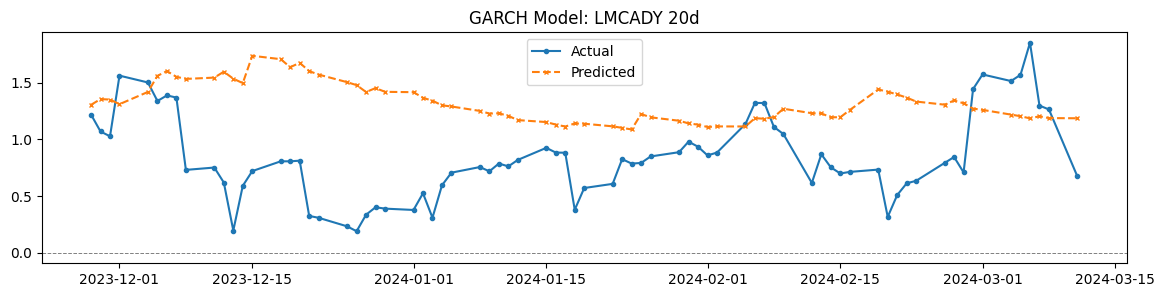

In [153]:
plot_predictions    (real_volatility_aligned, predicted_volatility_aligned, "LMCADY {}d".format(window))